In [153]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.pandas

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.pandas
import esri2gpd
import carto2gpd
import seaborn as sns
import geopandas as gpd
import cenpy
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from geopandas import GeoDataFrame
np.random.seed(42)

In [56]:
NPS = gpd.read_file("C:/Users/ssmat/Documents/NPS_-_National_Register_of_Historic_Places_Locations-shp/NPS_-_National_Register_of_Historic_Places_Locations.shp")

In [57]:
NPS = NPS[NPS['Status']!='Removed']
NPS = NPS[NPS['geometry'].isna() != True]

In [58]:
grped = NPS.groupby('State').count().reset_index()

In [67]:
# Add census data
acs = cenpy.remote.APIConnection("ACSDT5Y2018")

variables = ["NAME", "B01003_001E","B02008_001E","B23025_005E","B23025_001E","B29002_001E","B29002_006E","B29002_007E",
             "B29002_008E","B29003_001E","B29003_002E","B19001A_001E","B19001A_016E","B19001A_017E"]

In [68]:
state_data = acs.query(
    cols=variables,
    geo_unit="state:*",
)

In [66]:
state_data.head()

,NAME,B01003_001E,B02008_001E,B23025_005E,B23025_001E,B29002_001E,B29002_006E,B29002_007E,B29002_008E,B29003_001E,B29003_002E,B19001A_001E,B19001A_016E,B19001A_017E,B08126_001E,B08126_003E,state
0,Minnesota,5527358,4749380,119218,4379008,4037295,449792,906921,427276,3940147,344323,1907876,143913,143086,2879806,169795,27
1,Mississippi,2988762,1786914,110036,2350291,2228659,206747,279446,161062,2145906,384612,677533,30865,26200,1215697,79742,28
2,Missouri,6090062,5151022,155958,4864065,4585994,351725,764086,434106,4437928,546197,2017917,101409,94795,2855663,177468,29
3,Montana,1041732,953454,22433,838808,804263,67717,154949,73265,784859,100735,390495,17329,16291,499849,39939,30
4,Nebraska,1904760,1709927,36545,1483161,1358786,138686,272444,125607,1315343,128655,681092,36510,32127,980914,66644,31


In [69]:
for variable in variables:
    
    # Convert all variables EXCEPT for NAME
    if variable != "NAME":
        state_data[variable] = state_data[variable].astype(float)

In [71]:
# Convert to the data to floats
for col in variables[1:]:
    state_data[col] = state_data[col].astype(int)

state_data.columns = ['NAME', 'POPULATION','WHITE','UNEMPLOYED','TOTAL_EMP',"edu_total","edu_1","edu_2","edu_3",
                       "pov_tot","pov_below","inc_tot","inc_high1","inc_high2",'state']

In [72]:
state_data['white_per'] = state_data['WHITE'] / state_data['POPULATION'] *100

state_data['unemployed_per'] = state_data['UNEMPLOYED'] / state_data['TOTAL_EMP'] *100

state_data['edu_WithDegree_per'] = (state_data['edu_1'] + state_data['edu_2'] + state_data['edu_3']) / state_data['edu_total'] *100

state_data['BelowPoverty_per'] = state_data['pov_below'] / state_data['pov_tot'] *100

state_data['Above150_inc_per'] = (state_data['inc_high1'] + state_data['inc_high2']) / state_data['inc_tot'] *100

state_data = state_data[['NAME', 'POPULATION','white_per','unemployed_per','edu_WithDegree_per',
                           'BelowPoverty_per','Above150_inc_per']]

In [73]:
state_data['NAME'] = state_data['NAME'].str.upper() 

C:\Users\ssmat\miniconda3\envs\musa-550-fall-2020\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [74]:
NPS_census = state_data.merge(
    grped,
    left_on=["NAME"],
    right_on=["State"],
)

In [75]:
NPS_census['LISTINGS_PER_POP'] = NPS_census['OBJECTID'] / NPS_census['POPULATION']

In [76]:
NPS_census = NPS_census[['NAME','OBJECTID', 'LISTINGS_PER_POP','POPULATION','white_per','unemployed_per','edu_WithDegree_per',
                           'BelowPoverty_per','Above150_inc_per']]

NPS_census.columns = ['NAME', 'NPS_count', 'LISTINGS_PER_POP','POPULATION','white_per','unemployed_per','edu_WithDegree_per',
                           'BelowPoverty_per','Above150_inc_per']

In [77]:
NPS_census.head()

,NAME,NPS_count,LISTINGS_PER_POP,POPULATION,white_per,unemployed_per,edu_WithDegree_per,BelowPoverty_per,Above150_inc_per
0,MINNESOTA,1370,0.000248,5527358,85.924957,2.722489,44.187730,8.738836,15.042854
1,MISSISSIPPI,888,0.000297,2988762,59.787765,4.681803,29.042352,17.923059,8.422468
2,MISSOURI,1672,0.000275,6090062,84.580781,3.206331,33.796752,12.307478,9.723096
3,MONTANA,894,0.000858,1041732,91.525843,2.674390,36.795302,12.834789,8.609585
4,NEBRASKA,789,0.000414,1904760,89.771257,2.463994,39.501217,9.781099,10.077493


In [158]:
ny_stats =  NPS_census.loc[NPS_census['NAME']=='NEW YORK']
ny_stats.head()

,NAME,NPS_count,LISTINGS_PER_POP,POPULATION,white_per,unemployed_per,edu_WithDegree_per,BelowPoverty_per,Above150_inc_per
9,NEW YORK,4481,0.000228,19618453,66.13496,3.777809,43.542552,11.995018,19.973243


In [124]:
acs.set_mapservice("tigerWMS_ACS2018")

Connection to American Community Survey: 1-Year Estimates: Detailed Tables 5-Year(ID: https://api.census.gov/data/id/ACSDT5Y2018)
With MapServer: Census Current (2018) WMS

In [144]:
# Query for states
all_states = acs.mapservice.layers[84].query(where="1=1")

C:\Users\ssmat\miniconda3\envs\musa-550-fall-2020\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [146]:
all_states = all_states[['NAME', 'geometry']]
all_states['NAME'] = all_states['NAME'].str.upper() 
all_states.head()

,NAME,geometry
0,DELAWARE,"POLYGON ((-8433572.860 4764277.969, -8433575.8..."
1,NEW MEXICO,"POLYGON ((-11800569.118 4438447.089, -11800457..."
2,CALIFORNIA,"MULTIPOLYGON (((-13818818.759 5081091.495, -13..."
3,NEW JERSEY,"POLYGON ((-8370067.985 4952313.911, -8370086.4..."
4,WISCONSIN,"POLYGON ((-10340141.000 5723505.920, -10340101..."


In [161]:
# Split the data 70/30
train_set, test_set = train_test_split(NPS_census, 
                                       test_size=0.3, 
                                       random_state=42)


y_train = (train_set["NPS_count"]).values
y_test = (test_set["NPS_count"]).values

# The features
feature_cols = [
    "POPULATION",
    "white_per",
    "unemployed_per",
    "edu_WithDegree_per",
    "BelowPoverty_per",
    "Above150_inc_per",
]

X_train = train_set[feature_cols].values
X_test = test_set[feature_cols].values

In [162]:
# Make a linear model pipeline
linear_pipeline = make_pipeline(StandardScaler(), LinearRegression())

# Fit on the training data
linear_pipeline.fit(X_train, y_train)

# What's the test score?
linear_pipeline.score(X_test, y_test)

0.2376650457288224

In [163]:
# Make a random forest pipeline
forest_pipeline = make_pipeline(
    StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42)
)

# Run the 10-fold cross validation
scores = cross_val_score(
    forest_pipeline,
    X_train,
    y_train,
    cv=10,
)

# Report
print("R^2 scores = ", scores)
print("Scores mean = ", scores.mean())
print("Score std dev = ", scores.std())

R^2 scores =  [ 1.82188619e-03 -6.62451618e-02  2.88035348e-01  2.25172648e-01
 -4.17329507e+00  6.76052863e-01 -2.11994174e+00  7.93497742e-01
  4.72191290e-01 -3.04063072e+00]
Scores mean =  -0.6943340916671907
Score std dev =  1.6668140624789007


In [164]:
# Fit on the training data
forest_pipeline.fit(X_train, y_train)

# What's the test score? R-squared
forest_pipeline.score(X_test, y_test)

0.3202904184276929

### Which variables were most important?

In [165]:
# Extract the regressor from the pipeline
forest_model = forest_pipeline["randomforestregressor"]

In [ ]:
predictions = grid.best_estimator_.predict(test_set)

# Convert the predicted test values from log
X['prediction'] = np.exp(log_predictions)


In [166]:
# Create the data frame of importances
importance = pd.DataFrame(
    {"Feature": feature_cols, "Importance": forest_model.feature_importances_}
).sort_values("Importance")


importance.hvplot.barh(x="Feature", y="Importance")

:Bars   [Feature]   (Importance)

In [167]:
importance = importance.sort_values("Importance", ascending=False).iloc[:30]
importance.head(n=7)

,Feature,Importance
0,POPULATION,0.637854
3,edu_WithDegree_per,0.110886
2,unemployed_per,0.067768
1,white_per,0.067427
4,BelowPoverty_per,0.061467
5,Above150_inc_per,0.054598


In [168]:
# Extract the test data from the original dataset
# This will include the geometry data
X = NPS_census.loc[test_set.index]

In [169]:
X = X.merge(all_states, left_on='NAME', right_on='NAME')
X.head()

,NAME,NPS_count,LISTINGS_PER_POP,POPULATION,white_per,unemployed_per,edu_WithDegree_per,BelowPoverty_per,Above150_inc_per,geometry
0,TENNESSEE,1486,0.000223,6651089,79.620315,3.599195,31.558887,13.632462,9.507485,"POLYGON ((-9152918.296 4322240.375, -9152927.3..."
1,HAWAII,219,0.000154,1422029,43.060655,2.791942,40.937833,8.570690,19.841692,"MULTIPOLYGON (((-17302707.050 2290240.646, -17..."
2,LOUISIANA,1129,0.000242,4663616,63.935860,4.074247,27.398142,16.597788,11.793275,"POLYGON ((-10249066.406 3896364.550, -10249007..."
3,OHIO,3150,0.000271,11641879,84.072176,3.677700,33.432183,12.450188,10.216980,"POLYGON ((-9440254.719 5010777.407, -9440253.7..."
4,INDIANA,1336,0.000201,6637426,85.828256,3.451290,31.897548,11.815238,8.765106,"POLYGON ((-9743415.318 4935484.525, -9743414.5..."


In [170]:
test_set = test_set.merge(all_states, left_on='NAME', right_on='NAME')
test_set.head()

,NAME,NPS_count,LISTINGS_PER_POP,POPULATION,white_per,unemployed_per,edu_WithDegree_per,BelowPoverty_per,Above150_inc_per,geometry
0,TENNESSEE,1486,0.000223,6651089,79.620315,3.599195,31.558887,13.632462,9.507485,"POLYGON ((-9152918.296 4322240.375, -9152927.3..."
1,HAWAII,219,0.000154,1422029,43.060655,2.791942,40.937833,8.570690,19.841692,"MULTIPOLYGON (((-17302707.050 2290240.646, -17..."
2,LOUISIANA,1129,0.000242,4663616,63.935860,4.074247,27.398142,16.597788,11.793275,"POLYGON ((-10249066.406 3896364.550, -10249007..."
3,OHIO,3150,0.000271,11641879,84.072176,3.677700,33.432183,12.450188,10.216980,"POLYGON ((-9440254.719 5010777.407, -9440253.7..."
4,INDIANA,1336,0.000201,6637426,85.828256,3.451290,31.897548,11.815238,8.765106,"POLYGON ((-9743415.318 4935484.525, -9743414.5..."


In [171]:
X = GeoDataFrame(X)
test_set = GeoDataFrame(test_set)

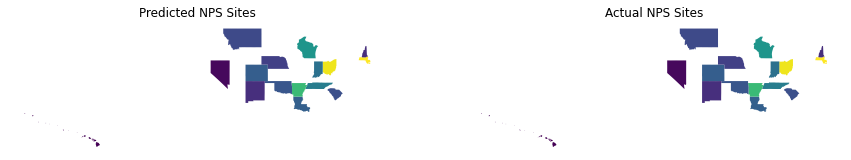

In [172]:
# Plot two columns
fig, axs = plt.subplots(ncols=2, figsize=(15,15))

# Predicted values
X.plot(ax=axs[0], column='NPS_count')
axs[0].set_title("Predicted NPS Sites")

# Actual values
X.plot(ax=axs[1], column='NPS_count')
axs[1].set_title("Actual NPS Sites")


axs[0].set_axis_off()
axs[1].set_axis_off()